# 1. GCN on Cora — Enc / Gt / Dec / L

- **Encoder (Enc)**: Two-layer Graph Convolutional Network (GCN) that transforms node features into hidden embeddings using neighborhood information; uses ReLU, dropout, and L2 weight decay on the first layer.
- **Graph transformation (Gt)**: Adjacency matrix `A` is preprocessed with self-loops and symmetric normalization (`gcn_filter`) to enable normalized message passing during convolution.
- **Decoder (Dec)**: Final GCN layer projects hidden embeddings to class logits, followed by softmax to output per-node class probabilities.
- **Loss (L)**: Masked categorical cross-entropy computed only on train nodes, with early stopping on validation loss to prevent overfitting; same loss, epochs, batch size, and masks as the MLP baseline for fairness.


## 2. Load and preprocess data (same splits/settings as MLP)

We load the preprocessed arrays from `../data/`, add self-loops and normalize the adjacency for GCN, and convert it to a TensorFlow sparse tensor for efficient message passing.


In [12]:
import os
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from spektral.layers import GCNConv
from spektral.utils import convolution
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load arrays from ../data/ (robust to cwd)
from pathlib import Path

cwd = Path.cwd().resolve()
repo_root = cwd if (cwd / "data").exists() else cwd.parent
DATA_DIR = repo_root / "data"

X = np.load(DATA_DIR / "X.npy").astype(np.float32)
y = np.load(DATA_DIR / "y.npy").astype(np.float32)
A = sp.load_npz(DATA_DIR / "A.npz")
train_mask = np.load(DATA_DIR / "train_mask.npy")
val_mask = np.load(DATA_DIR / "val_mask.npy")
test_mask = np.load(DATA_DIR / "test_mask.npy")

# Convert to tensors
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)

# Preprocess adjacency: add self-loops + symmetric normalization
A_processed = convolution.gcn_filter(A).tocoo()
A_tensor = tf.sparse.SparseTensor(
    np.array([A_processed.row, A_processed.col]).T,
    A_processed.data.astype(np.float32),
    A_processed.shape,
)
A_tensor = tf.sparse.reorder(A_tensor)

# Ensure masks are float tensors for sample weights
train_mask = tf.constant(train_mask.astype(np.float32))
val_mask = tf.constant(val_mask.astype(np.float32))
test_mask = tf.constant(test_mask.astype(np.float32))

print("✅ Loaded data from disk successfully\n")
print(f"X shape:        {X.shape}")
print(f"y shape:        {y.shape}")
print(f"A shape:        {A.shape} (sparse)")
print(f"Train samples:  {tf.reduce_sum(train_mask).numpy()}")
print(f"Val samples:    {tf.reduce_sum(val_mask).numpy()}")
print(f"Test samples:   {tf.reduce_sum(test_mask).numpy()}")


✅ Loaded data from disk successfully

X shape:        (2708, 1433)
y shape:        (2708, 7)
A shape:        (2708, 2708) (sparse)
Train samples:  140.0
Val samples:    500.0
Test samples:   1000.0


## 3. Prepare masks and shapes

We keep the same splits as the MLP baseline (train/val/test masks) for fairness.


In [13]:
num_nodes, num_features = X.shape
num_classes = y.shape[1]

print("Data splits:")
print(f"  Train: {tf.reduce_sum(train_mask).numpy()} nodes")
print(f"  Val:   {tf.reduce_sum(val_mask).numpy()} nodes")
print(f"  Test:  {tf.reduce_sum(test_mask).numpy()} nodes")
print(f"  Num features: {num_features}")
print(f"  Num classes:  {num_classes}")


Data splits:
  Train: 140.0 nodes
  Val:   500.0 nodes
  Test:  1000.0 nodes
  Num features: 1433
  Num classes:  7


## 4. Build the GCN model (replacing MLP with graph convolutions)

We use two GCN layers with ReLU + dropout (first layer has L2 weight decay), followed by a softmax output. Loss: categorical cross-entropy (masked), same epochs, batch size, and early stopping as the MLP baseline.


In [14]:
class NoMaskGCN(GCNConv):
    def call(self, inputs, mask=None):
        if isinstance(mask, (list, tuple)) and all(m is None for m in mask):
            mask = None
        return super().call(inputs, mask=mask)


dropout_rate = 0.5
l2_reg = 5e-4
learning_rate = 0.01

X_in = layers.Input(shape=(num_features,), name="X_in")
A_in = layers.Input((None,), sparse=True, name="A_in")

x = layers.Dropout(dropout_rate)(X_in)
x = NoMaskGCN(16, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))([x, A_in])
x = layers.Dropout(dropout_rate)(x)
outputs = NoMaskGCN(num_classes, activation="softmax")([x, A_in])

model = keras.Model(inputs=[X_in, A_in], outputs=outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ X_in (InputLayer)   │ (None, 1433)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1433)      │          0 │ X_in[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ A_in (InputLayer)   │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ no_mask_gcn_2       │ (None, 16)        │     22,944 │ dropout_3[0][0],  │
│ (NoMaskGCN)         │                   │            │ A_in[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 16)        │          0 │ no_mask_gcn_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ no_mask_gcn_3       │ (None, 7)         │        119 │ dropout_4[0][0],  │
│ (NoMaskGCN)         │                   │            │ A_in[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,063 (90.09 KB)

 Trainable params: 23,063 (90.09 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train with masked loss (same epochs, batch size, early stopping as MLP)

We reuse: epochs = 100, batch_size = 256, categorical cross-entropy, and early stopping on validation loss (patience = 10). Masks ensure loss/metrics are computed only on the respective splits.


Epoch 001 | loss 1.9323 | val_loss 1.8923 | train_acc 0.2143 | val_acc 0.3860
Epoch 002 | loss 1.8609 | val_loss 1.8278 | train_acc 0.4000 | val_acc 0.5600
Epoch 003 | loss 1.7464 | val_loss 1.7407 | train_acc 0.6429 | val_acc 0.6520
Epoch 004 | loss 1.6249 | val_loss 1.6482 | train_acc 0.7143 | val_acc 0.6880
Epoch 005 | loss 1.4904 | val_loss 1.5589 | train_acc 0.7429 | val_acc 0.7100
Epoch 006 | loss 1.3517 | val_loss 1.4752 | train_acc 0.8286 | val_acc 0.7320
Epoch 007 | loss 1.2677 | val_loss 1.3934 | train_acc 0.8286 | val_acc 0.7540
Epoch 008 | loss 1.1345 | val_loss 1.3171 | train_acc 0.8714 | val_acc 0.7640
Epoch 009 | loss 1.0449 | val_loss 1.2439 | train_acc 0.8429 | val_acc 0.7780
Epoch 010 | loss 0.9381 | val_loss 1.1771 | train_acc 0.9143 | val_acc 0.7840
Epoch 011 | loss 0.8407 | val_loss 1.1179 | train_acc 0.9286 | val_acc 0.7880
Epoch 012 | loss 0.7655 | val_loss 1.0656 | train_acc 0.8714 | val_acc 0.7900
Epoch 013 | loss 0.6749 | val_loss 1.0198 | train_acc 0.9143 | v

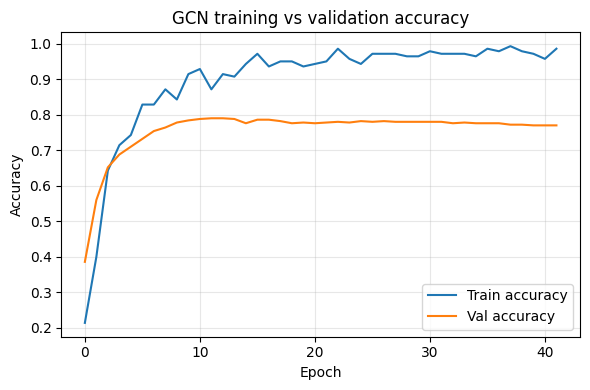

In [15]:
epochs = 100
patience = 10

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = keras.losses.CategoricalCrossentropy(reduction="none")

history_acc = []
history_val_acc = []
best_val_loss = float("inf")
wait = 0
best_weights = None

train_mask_tf = tf.convert_to_tensor(train_mask)
val_mask_tf = tf.convert_to_tensor(val_mask)
mask_train_norm = tf.reduce_sum(train_mask_tf)
mask_val_norm = tf.reduce_sum(val_mask_tf)

for epoch in range(1, epochs + 1):
    with tf.GradientTape() as tape:
        logits = model([X, A_tensor], training=True)
        loss_raw = loss_fn(y, logits)
        loss = tf.reduce_sum(loss_raw * train_mask_tf) / mask_train_norm
        total_loss = loss + tf.add_n(model.losses)
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Train metrics
    train_pred = tf.argmax(logits, axis=1)
    train_true = tf.argmax(y, axis=1)
    train_acc = tf.reduce_mean(tf.cast(tf.equal(train_pred, train_true), tf.float32) * train_mask_tf) / (mask_train_norm / tf.cast(tf.shape(train_true)[0], tf.float32))

    # Val metrics
    val_logits = model([X, A_tensor], training=False)
    val_loss_raw = loss_fn(y, val_logits)
    val_loss = tf.reduce_sum(val_loss_raw * val_mask_tf) / mask_val_norm
    val_pred = tf.argmax(val_logits, axis=1)
    val_true = tf.argmax(y, axis=1)
    val_acc = tf.reduce_mean(tf.cast(tf.equal(val_pred, val_true), tf.float32) * val_mask_tf) / (mask_val_norm / tf.cast(tf.shape(val_true)[0], tf.float32))

    history_acc.append(float(train_acc))
    history_val_acc.append(float(val_acc))

    print(f"Epoch {epoch:03d} | loss {float(loss):.4f} | val_loss {float(val_loss):.4f} | train_acc {float(train_acc):.4f} | val_acc {float(val_acc):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = float(val_loss)
        wait = 0
        best_weights = model.get_weights()
    else:
        wait += 1
        if wait > patience:
            print("Early stopping")
            break

if best_weights is not None:
    model.set_weights(best_weights)

# Training/validation accuracy plot
plt.figure(figsize=(6, 4))
plt.plot(history_acc, label="Train accuracy")
plt.plot(history_val_acc, label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("GCN training vs validation accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Evaluate on train/val/test with accuracy, precision, recall, F1 (macro)

We compute metrics on each split using the masks. If test accuracy is not higher than the MLP (~80%), stop and debug before proceeding.


In [16]:
# Predictions for all nodes (no batching)
logits = model([X, A_tensor], training=False)
labels_true = tf.argmax(y, axis=1).numpy()
labels_pred = tf.argmax(logits, axis=1).numpy()

results = {}
for split_name, mask in {
    "train": train_mask,
    "val": val_mask,
    "test": test_mask,
}.items():
    mask_np = mask.numpy().astype(bool)
    true_split = labels_true[mask_np]
    pred_split = labels_pred[mask_np]
    acc = accuracy_score(true_split, pred_split)
    prec, rec, f1, _ = precision_recall_fscore_support(
        true_split, pred_split, average="macro", zero_division=0
    )
    results[split_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }
    print(f"{split_name.title()} metrics:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1:        {f1:.4f}\n")

# Safety check: ensure test accuracy is reasonable (>0.80 expected)
if results["test"]["accuracy"] < 0.80:
    raise ValueError("Test accuracy < 0.80; please debug before proceeding.")


Train metrics:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1:        1.0000

Val metrics:
  Accuracy:  0.7800
  Precision: 0.7508
  Recall:    0.7889
  F1:        0.7642

Test metrics:
  Accuracy:  0.8080
  Precision: 0.7916
  Recall:    0.8201
  F1:        0.8025



## 7. Save test metrics to `results/metrics.csv`

We append the test split metrics for the GCN model to the shared CSV (same format as MLP).


In [17]:
# 7.1 Save metrics to results/metrics.csv

import csv
import os

RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

metrics_path = os.path.join(RESULTS_DIR, "metrics.csv")
file_exists = os.path.isfile(metrics_path)

fieldnames = [
    "model",
    "dataset",
    "test_accuracy",
    "test_precision_macro",
    "test_recall_macro",
    "test_f1_macro",
]

row = {
    "model": "GCN",
    "dataset": "cora",
    "test_accuracy": f"{acc:.4f}",
    "test_precision_macro": f"{prec:.4f}",
    "test_recall_macro": f"{rec:.4f}",
    "test_f1_macro": f"{f1:.4f}",
}

with open(metrics_path, mode="a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if not file_exists:
        writer.writeheader()
    writer.writerow(row)

print(f"✅ Saved GCN metrics to {metrics_path}")


✅ Saved GCN metrics to ../results/metrics.csv
